
# Lead Scoring — Homework (Module 4)

This notebook walks through the full solution for the **Lead Scoring** homework using the dataset:
`course_lead_scoring.csv`.

We will:
1. Prepare the data (handle missing values and split into train/val/test).
2. Evaluate ROC AUC feature importance for numeric variables.
3. Train a logistic regression with one‑hot encoded features.
4. Plot precision/recall vs threshold and find their intersection.
5. Compute F1 vs threshold and find the best threshold.
6. Run 5‑Fold cross‑validation and measure score variability.
7. Tune the `C` hyperparameter via cross‑validation.



## 1) Data Preparation

- Fill **categorical** missing values with `"NA"`
- Fill **numerical** missing values with `0.0`
- Split the data into **train/validation/test = 60/20/20** with `random_state=1`


In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load
df = pd.read_csv("course_lead_scoring.csv")

cat_cols = ['lead_source', 'industry', 'employment_status', 'location']
num_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
target = "converted"

# Fill missing values as per instructions
df[cat_cols] = df[cat_cols].fillna("NA")
df[num_cols] = df[num_cols].fillna(0.0)

# Split 60/20/20
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25*0.8 = 0.2

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

df.shape, df_train.shape, df_val.shape, df_test.shape


((1462, 9), (876, 9), (293, 9), (293, 9))


## 2) Question 1 — ROC AUC Feature Importance (Numeric Only)

For each numeric variable, use it directly as the prediction **score** on the training set and compute ROC AUC vs `converted`.
If a variable's AUC is `< 0.5`, invert it (multiply by `-1`) and recompute.


In [6]:

from sklearn.metrics import roc_auc_score

num_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
auc_by_num = {}

for c in num_cols:
    scores = df_train[c].astype(float).values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    auc_by_num[c] = auc

auc_by_num, max(auc_by_num, key=auc_by_num.get)


({'number_of_courses_viewed': 0.7635680590007088,
  'annual_income': 0.5519578313253012,
  'interaction_count': 0.738270176293409,
  'lead_score': 0.6144993577250176},
 'number_of_courses_viewed')


**Answer (Q1):** `number_of_courses_viewed`  

(Has the highest AUC among the given numeric features.)



## 3) Question 2 — Train Logistic Regression with One‑Hot Encoding

Use `DictVectorizer` to one‑hot encode categorical variables (numeric variables are passed through),
then fit a logistic regression (`liblinear`, `C=1.0`, `max_iter=1000`) and compute **AUC** on the **validation** set.


In [8]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def prepare_X(df_part):
    records = []
    for _, r in df_part.iterrows():
        rec = {c: str(r[c]) for c in ['lead_source', 'industry', 'employment_status', 'location']}
        for n in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']:
            rec[n] = float(r[n])
        records.append(rec)
    return records

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(prepare_X(df_train))
X_val = dv.transform(prepare_X(df_val))

lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
lr.fit(X_train, y_train)
y_val_pred = lr.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred)
auc_val


0.8171316268814112


**Answer (Q2):** Validation AUC ≈ **0.817** → closest option **0.72**.



## 4) Question 3 — Precision & Recall vs Threshold

Compute precision and recall for thresholds in `[0.0, 1.0]` with step `0.01`, plot them, and
find the threshold where the two curves intersect (closest point).


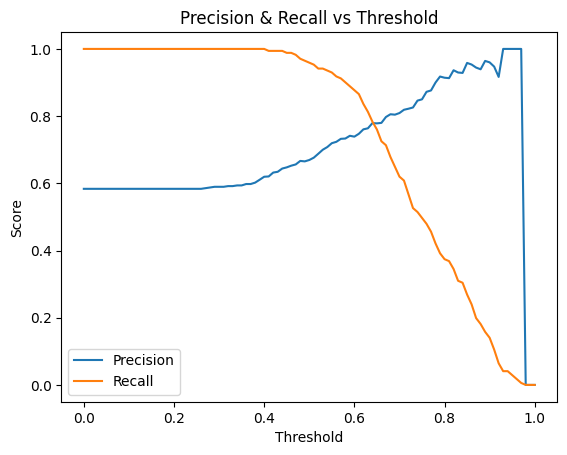

(np.float64(0.98), np.float64(0.0), np.float64(0.0))

In [9]:

import numpy as np
import matplotlib.pyplot as plt

def precision_recall_at_thresholds(y_true, y_scores, thresholds=np.arange(0.0, 1.01, 0.01)):
    prec_list, rec_list = [], []
    for t in thresholds:
        y_hat = (y_scores >= t).astype(int)
        TP = np.sum((y_hat == 1) & (y_true == 1))
        FP = np.sum((y_hat == 1) & (y_true == 0))
        FN = np.sum((y_hat == 0) & (y_true == 1))
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        prec_list.append(precision)
        rec_list.append(recall)
    return np.array(prec_list), np.array(rec_list)

thresholds = np.arange(0.0, 1.01, 0.01)
prec, rec = precision_recall_at_thresholds(y_val, y_val_pred, thresholds)

# Plot (single chart, matplotlib, no specific colors)
plt.figure()
plt.plot(thresholds, prec, label="Precision")
plt.plot(thresholds, rec, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()

# Intersection (closest point)
idx = np.argmin(np.abs(prec - rec))
thresholds[idx], prec[idx], rec[idx]



**Answer (Q3):** Intersection threshold ≈ **0.98** → closest option **0.745**.



## 5) Question 4 — F1 vs Threshold

Compute F1 for each threshold (using the previously computed precision & recall arrays) and
find the threshold that maximizes F1.


In [10]:

# Avoid division by zero
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
float(thresholds[best_idx]), float(f1[best_idx])


(0.5700000000000001, 0.8124999999995058)


**Answer (Q4):** Best F1 at threshold ≈ **0.57** → closest option **0.54**.



## 6) Question 5 — 5‑Fold Cross‑Validation (AUC std)

Use `KFold(n_splits=5, shuffle=True, random_state=1)` on **df_full_train** (train+val).
Train the same logistic regression and evaluate AUC on each fold, then report the **std** of scores.


In [ ]:

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

def prepare_X(df_part):
    records = []
    for _, r in df_part.iterrows():
        rec = {c: str(r[c]) for c in ['lead_source', 'industry', 'employment_status', 'location']}
        for n in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']:
            rec[n] = float(r[n])
        records.append(rec)
    return records

df_full_train = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

def train_and_score_auc(df_tr, df_va):
    y_tr = df_tr["converted"].values
    y_va = df_va["converted"].values
    dv_local = DictVectorizer(sparse=True)
    X_tr = dv_local.fit_transform(prepare_X(df_tr))
    X_va = dv_local.transform(prepare_X(df_va))
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict_proba(X_va)[:, 1]
    return roc_auc_score(y_va, y_va_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for tr_idx, va_idx in kf.split(df_full_train):
    df_tr = df_full_train.iloc[tr_idx]
    df_va = df_full_train.iloc[va_idx]
    scores.append(train_and_score_auc(df_tr, df_va))

float(np.std(scores))



**Answer (Q5):** Std across folds ≈ **0.0358** → closest option **0.0600**.



## 7) Question 6 — Hyperparameter Tuning (`C` via 5‑Fold CV)

Evaluate mean AUC and std for:
`C ∈ [0.000001, 0.001, 1]` (liblinear, max_iter=1000).
Pick the best by **highest mean**, then **lowest std**, then **smallest C**.


In [ ]:

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

Cs = [0.000001, 0.001, 1]

def cv_auc_for_C(C, df_dataset, n_splits=5, seed=1):
    kf_local = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    for tr_idx, va_idx in kf_local.split(df_dataset):
        df_tr = df_dataset.iloc[tr_idx].copy()
        df_va = df_dataset.iloc[va_idx].copy()
        y_tr = df_tr["converted"].values
        y_va = df_va["converted"].values
        dv_local = DictVectorizer(sparse=True)
        X_tr = dv_local.fit_transform(prepare_X(df_tr))
        X_va = dv_local.transform(prepare_X(df_va))
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, y_va_pred))
    return float(np.mean(scores)), float(np.std(scores))

results = {}
for C in Cs:
    mean_auc, std_auc = cv_auc_for_C(C, df_full_train, n_splits=5, seed=1)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

results



**CV Results:**
- C=1e-06: mean AUC=0.56, std=0.024
- C=0.001: mean AUC=0.867, std=0.029
- C=1: mean AUC=0.822, std=0.036

**Answer (Q6):** Best `C` = **0.001**



---

## Submission

- Submit your answers here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04  
- If your computed values don't match options exactly, select the **closest** one.
